# Risk of Bias Resource - IAA

In [122]:
# Generic imports
from os import listdir, path
from os.path import isfile, join
import json
import string
import itertools
from itertools import chain
from collections import defaultdict
from collections import Counter
import numpy as np
import re

# Connect to tagtog API
from lxml import html
from bs4 import BeautifulSoup
from requests import get
from requests.auth import HTTPBasicAuth, HTTPDigestAuth
import urllib

# Specific imports

from nltk.tokenize import WhitespaceTokenizer
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import krippendorff

# visualization
import matplotlib.pyplot as plt

In [72]:
# The list studies from RoBuster on which IAA is being calculated

# This study is not randomized: a.fDxxb6jpRMdToWutLQbuzUE3Be-Rossetti_2020_RiskRatio_Death_sixmonths_Hilfiker_with_Protocol.pdf

study_list = [
"a0r3RPiR2TQwAqPtuyV9W1MMEZhm-Pasha_2013_mean_perinatal_mortality_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf",
"a0tUrhW6ZrE_Rx5DUB.s2Y0i9HRm-Osteras_2019_Patient_Reporting_Quality_of_Care_6months_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf",
"a1c0YDDvTSHcrXcQ8Ss6oSc4Txyi-Lagro_2022_HealthLiveBirth_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf",
"aCONOKOlosHfudHZfY7GPEJIks_a-Solomons_2020_VISA_A_12months_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf",
"aLsldY293awa54LgLf7ppRHoe8Ai-Becker_2020_restriction_muscle_strength_at_3rdFollowup_up_IAA_Hilfiker_Sattelmayer_no_protocol_found.pdf",
"apfNIGtsgEGA.K9CIFltDaZVcuI0-Darlow_2019_Roland_Morris_Disability_Q_sixMonths_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf",
"aRawpYF6R2rjxGXzQf0kI4_AbmZq-Bai_2020_GAD_7_at_3monts_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf",
"atgacPROAdZJsURf1vPiVxL4jShe-Friedli_2020_mortality_within_180days_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf",
"aWszy6LcqsAKCT0BbpA.2A8CbnMO-An_2020_VO2peak_at_6months_IAA_Hilfiker_Sattelmayer_with_Protocol.pdf"
]

In [73]:
# Map the entity codes from tagtog to the correct labels from the annotation scheme.

entity2label = {
  "e_8" : "1_3_No_Good",
  "e_16" : "2_3_Yes_Bad",
  "e_3" : "1_1_No_Information",
  "e_27" : "3_2_No_Bad",
  "e_35" : "4_2_No_Good",
  "e_38" : "4_3_Yes_Bad",
  "e_46" : "5_2_No_Bad",
  "e_34" : "4_1_Yes_Bad",
  "e_41" : "4_5_No_Good",
  "e_2" : "1_1_No_Bad",
  "e_30" : "3_3_No_Good",
  "e_12" : "2_1_ProbablyYes_Bad",
  "e_23" : "2_7_Yes_Bad",
  "e_45" : "5_2_Yes_Good",
  "e_31" : "3_4_Yes_Bad",
  "e_20" : "2_5_No_Bad",
  "e_18" : "2_4_Yes_Bad",
  "e_42" : "4_5_Yes_Bad",
  "e_29" : "3_3_Yes_Bad",
  "e_7" : "1_3_Yes_Bad",
  "e_14" : "2_2_Yes_Bad",
  "e_5" : "1_2_No_Bad",
  "e_11" : "2_1_Yes_Bad",
  "e_22" : "2_6_No_Bad",
  "e_44" : "5_1_Yes_Good",
  "e_33" : "4_1_No_Good",
  "e_48" : "5_3_Yes_Bad",
  "e_19" : "2_5_Yes_Good",
  "e_37" : "4_3_No_Good",
  "e_15" : "2_3_No_Good",
  "e_26" : "3_1_Yes_Good",
  "e_6" : "1_2_No_Information",
  "e_39" : "4_4_No_Good",
  "e_40" : "4_4_Yes_Bad",
  "e_21" : "2_6_Yes_Good",
  "e_28" : "3_2_Yes_Good",
  "e_17" : "2_4_No_Good",
  "e_9" : "1_3_No_Information",
  "e_10" : "2_1_No_Good",
  "e_4" : "1_2_Yes_Good",
  "e_32" : "3_4_No_Good",
  "e_43" : "5_1_No_Bad",
  "e_36" : "4_2_Yes_Bad",
  "e_47" : "5_3_No_Good",
  "e_1" : "1_1_Yes_Good",
  "e_25" : "3_1_No_Bad",
  "e_24" : "2_7_No_Good",
  "e_13" : "2_2_No_Good"
}

In [74]:
# List the signalling questions
sq_list = [value[0:3] for value in entity2label.values()]

print(sq_list)

['1_3', '2_3', '1_1', '3_2', '4_2', '4_3', '5_2', '4_1', '4_5', '1_1', '3_3', '2_1', '2_7', '5_2', '3_4', '2_5', '2_4', '4_5', '3_3', '1_3', '2_2', '1_2', '2_1', '2_6', '5_1', '4_1', '5_3', '2_5', '4_3', '2_3', '3_1', '1_2', '4_4', '4_4', '2_6', '3_2', '2_4', '1_3', '2_1', '1_2', '3_4', '5_1', '4_2', '5_3', '1_1', '3_1', '2_7', '2_2']


In [75]:
signalling_questions = set()

for k,v in entity2label.items():
    v_mod = str(v).split('_', 2)
    v_mod = v_mod[0]+'_'+v_mod[1]
    signalling_questions.add( v_mod )

In [76]:
# Get plain texts and the members annotations
plain_text = '/mnt/nas2/data/systematicReview/RoB/December_2022/rob-tagtog/plain.html/pool/'
member_annotations = '/mnt/nas2/data/systematicReview/RoB/December_2022/rob-tagtog/ann.json/members/'

# The members who annotated the documents
project_members = ['roger-annotation', 'martin-annotation']
projet_admin = ['anjDhr']
member_dir = listdir( member_annotations )

In [77]:
# TODO: keep or to remove?

def find_whitespace(st):
    for index, character in enumerate(st):
        if character in string.whitespace:
            yield index

In [78]:
# TODO: keep or to remove?

def get_combinations(l):
    yield from itertools.product(l, l)

In [79]:
# Initialize tokenizer
tk = WhitespaceTokenizer()

# Parse plain text files for the trial annotation project

plain_text_dict = dict()
plain_text_doclen = dict()

plain_texts = [f for f in listdir(plain_text) if isfile(join(plain_text, f))]

for plaintext_file in plain_texts:
    
    name_reduced = str(plaintext_file).replace('.plain.html', '')
    if name_reduced in study_list:
        plaintext_path = path.join(plain_text, plaintext_file)

        #with open(plaintext_path, "r") as f:
        #    page = f.read()
        page = open(plaintext_path, encoding="utf8")

        soup = BeautifulSoup(page)
        trial_doc_name = str(soup.head.title.text).split('-')[0]

        text_list = soup.find_all("pre")

        document_parts = {}
        doc_tok_len = 0
        for l in text_list:

            document_parts[ l.get('id') ] = l.text
            token_text = tk.tokenize(l.text)
            doc_tok_len = doc_tok_len + len(token_text)

        plain_text_dict[trial_doc_name] = document_parts
        plain_text_doclen[trial_doc_name] = doc_tok_len

In [80]:
{k: v for k, v in sorted(plain_text_doclen.items(), key=lambda item: item[1])}

{'aLsldY293awa54LgLf7ppRHoe8Ai': 9012,
 'aRawpYF6R2rjxGXzQf0kI4_AbmZq': 9089,
 'a0r3RPiR2TQwAqPtuyV9W1MMEZhm': 9554,
 'atgacPROAdZJsURf1vPiVxL4jShe': 10406,
 'aWszy6LcqsAKCT0BbpA.2A8CbnMO': 10428,
 'a0tUrhW6ZrE_Rx5DUB.s2Y0i9HRm': 11024,
 'aCONOKOlosHfudHZfY7GPEJIks_a': 12157,
 'a1c0YDDvTSHcrXcQ8Ss6oSc4Txyi': 12797,
 'apfNIGtsgEGA.K9CIFltDaZVcuI0': 14178}

In [81]:
# List member annotation files

doc_annot_count = 0
document_annotations = dict()

member_annot_files = {}

for m, member in enumerate(member_dir):
    
    if member not in projet_admin:
        
        member_annot_dir = member_annotations + str(member) + '/'
        
        member_annot_dir = path.join(member_annotations, member, 'pool')
                
        annotation_files = [path.join(member_annot_dir, f) for f in listdir(member_annot_dir) if isfile(join(member_annot_dir, f))]
        
        annotation_dict = {}
        
        # generate a dictionary of document_number : annotations parsed
        for annotation_file in annotation_files:
            name_reduced = str(annotation_file).split('/')[-1]
            name_reduced = str(name_reduced).replace('.ann.json', '')
            if name_reduced in study_list:
                trial_doc_name = str(name_reduced).split('-')[0]
                
                with open(annotation_file, 'r') as af:
                    data = json.load(af)
                    annotation_dict[trial_doc_name] = data['entities']
                    
        member_annot_files[member] = annotation_dict

In [82]:
def get_docclass_iaa(ann1, ann2):  
    
    annot1 = []
    annot2 = []

    for i in range(1, 11):

        if str(i) in ann1 and str(i) in ann2:
            #print( ann1[str(i)], ann2[str(i)] )
            annot1.append( ann1[str(i)] )
            annot2.append( ann2[str(i)] )

            
    return annot1, annot2

In [83]:
def get_doc_annot(rob_class):
    
    # Document > people > class
    print(rob_class)

    roger_doc = dict()
    martin_doc = dict()

    for doc_number, v in document_annotations.items():

        for doc_values in v:

            if rob_class in doc_values:

                if 'roger' in doc_values[rob_class]['confidence']['who'][0].replace('user:', ''):
                    roger_doc[doc_number] = doc_values[dl]['value']
                    #print(doc_number , ' : ' , doc_values[dl]['value'])
                if 'martin' in doc_values[rob_class]['confidence']['who'][0].replace('user:', ''):
                    martin_doc[doc_number] = doc_values[dl]['value']
                    #print(doc_number , ' : ' , doc_values[dl]['value'])
                    
                    
    return roger_doc, martin_doc

In [84]:
# Calculate the total number of annotations

annot_count = 0

sq_count = []

for mem_name,v in member_annot_files.items():

    for doc_num, v_ in v.items():
        
        annot_count = annot_count + len( v_ )
        
        for a in v_:
            
            ent = a['classId']
            ent_name = entity2label[ent]
            sq = "_".join(ent_name.split("_", 2)[:2])
            
            sq_count.append( sq )

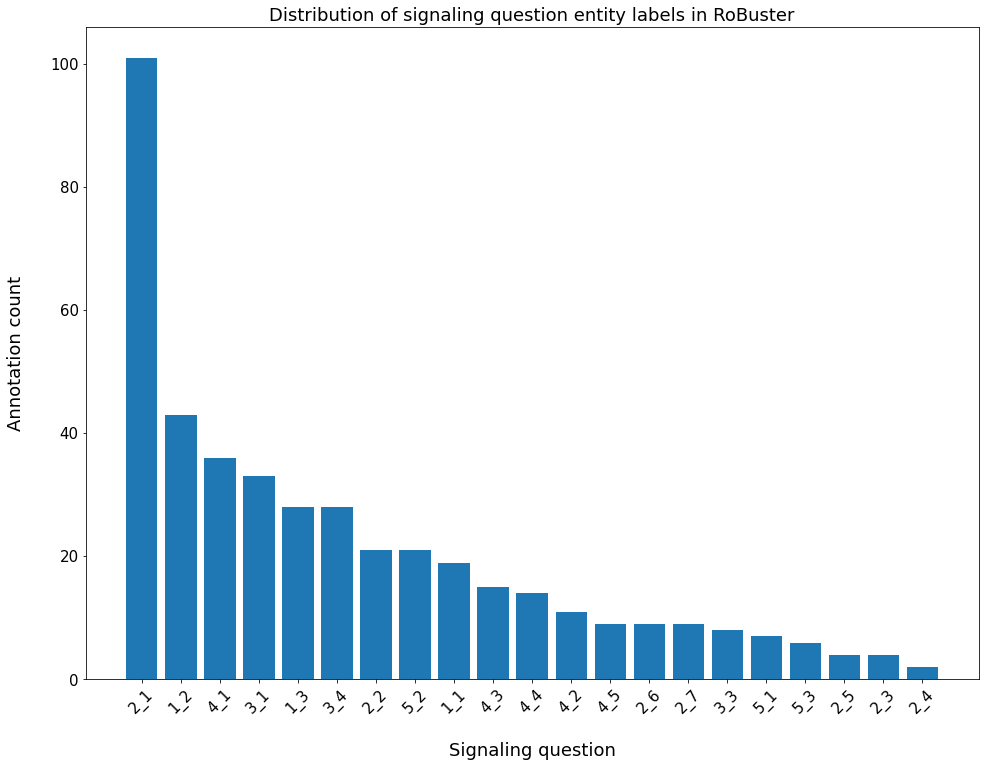

In [85]:
x = Counter(sq_count)
x = dict(x.most_common())
bars, values = zip(*x.items())

fig = plt.figure(figsize=(16, 12))
y_pos = np.arange(len(bars))

# Create bars
plt.bar(y_pos, values)

# Create names on the x-axis
plt.xticks(y_pos, bars, fontsize=15, rotation=45)
plt.yticks(fontsize=15)


plt.xlabel('Signaling question', fontweight='normal', color = 'black', fontsize='18',labelpad=25)
plt.ylabel('Annotation count', fontweight='normal', color = 'black', fontsize='18',labelpad=25)
plt.title('Distribution of signaling question entity labels in RoBuster', fontsize='18')

# Show graphic
plt.show()

## Parse Annotations

In [86]:
def parseAnnotations(member_annotations):

    annotation_docs = dict()
    annotation_docs_text = dict()

    for k,v in member_annotations.items():
        
        annotation_dict = dict()
        annotation_text = []

        for counter, a in enumerate(v):

            document_part = a['part']
            offset_start = a['offsets'][0]['start']
            offset_end = offset_start + len(a['offsets'][0]['text'])
            entity_text = a['offsets'][0]['text']
            document = plain_text_dict[k][document_part]

            document_entity_match = document[offset_start:offset_end]    
            document_entity_match_label = a['classId']
            assert len(entity_text) == len(document_entity_match)

            match_label_list = len( entity_text ) * [document_entity_match_label]

            document_char_labels = [0] * len(document)
            document_char_labels[offset_start:offset_end] = match_label_list

            annotation_text.append( ( entity_text, [entity2label[x] for x in list(set(document_char_labels)) if x in entity2label ] ) )

            if document_part not in annotation_dict:
                annotation_dict[document_part] = [ document_char_labels ]
            else:
                annotation_dict[document_part].append( document_char_labels )

        annotation_docs[k] = annotation_dict
        annotation_docs_text[k] = annotation_text
        
    return annotation_docs, annotation_docs_text

In [87]:
def char2tokAnnot(char_annotations):
    
    token_annotations = {}
    
    for k_a, v_a in char_annotations.items():
        #print(k_a) # document number
        
        token_annotations[k_a] = {}

        for k_a_, v_a_ in v_a.items(): # convert char annot to tok annot
            #print(k_a_) # document part

            text =  plain_text_dict[k_a][k_a_]
            white_space_spans = list(WhitespaceTokenizer().span_tokenize(plain_text_dict[k_a][k_a_]))
            tokens = [ text[ ws[0] : ws[1] ] for ws in  white_space_spans ]
            
            for v_a_i in v_a_:
            
                labels = [ list( set(v_a_i[ ws[0] : ws[1] ]) ) for ws in  white_space_spans ]
                #labels_clean = [ list(filter(lambda num: num != 0, l))[0] if len( l ) > 1 else l[0] for l in labels ]
                labels_clean = [ list(filter(lambda num: num != 0, l)) if len( l ) > 1 else l for l in labels ]
                #print('Clean labels: ' , labels_clean)
            
                assert len(v_a_i) == len(plain_text_dict[k_a][k_a_])                
                assert len( tokens ) == len( labels )
            
                if k_a_ not in token_annotations[k_a]:
                    token_annotations[k_a][k_a_] = {}
                    token_annotations[k_a][k_a_]['tokens'] = tokens
                    token_annotations[k_a][k_a_]['labels'] = labels_clean
                                        
                elif k_a_ in token_annotations[k_a]:
                    old_labels = token_annotations[k_a][k_a_]['labels']
                    new_labels = [ list(set(old_labels[n] + l)) for n, l in enumerate(labels_clean)]
                    
                    #new_labels = [ old_labels[n].append( l ) for n, l in enumerate(labels_clean) ]
                    #print( new_labels )
                    
                    assert len( old_labels ) == len( new_labels )
                    
                    token_annotations[k_a][k_a_]['labels'] = new_labels
            #break
                
    return token_annotations

In [88]:
annotations = dict()
annotation_text = dict()

for k,v in member_annot_files.items():

    if len( list(v.keys()) ) >= 8: # restricts it to those who completed annotations
        print(k)
        char_annotations, annot_text = parseAnnotations(v)
        tok_annotations = char2tokAnnot(char_annotations)
        annotations[k] = tok_annotations
        annotation_text[k] = annot_text

roger-annotation
martin-annotation


# Calculate Inter Annotator Agreement

In [89]:
def flatenAnnotations(annotator1, annotator2, annotations_all):
    
    annot1 = annotations_all[annotator1]
    annot2 = annotations_all[annotator2]
    annot1_flattened = []
    annot2_flattened = []
    
    docs = list(annot1.keys())
    
    for doc in docs:
        #print('Document number: ', doc)
        doc_parts = list(annot1[doc].keys())
        
        for doc_part in doc_parts:
            #print( doc_part )
            if doc_part in annot1[doc] and doc_part in annot2[doc]:
                annot1_flattened.extend( annot1[doc][doc_part]['labels'] )
                annot2_flattened.extend( annot2[doc][doc_part]['labels'] )
                
            elif doc_part in annot1[doc] and doc_part not in annot2[doc]:
                annot1_flattened.extend( annot1[doc][doc_part]['labels'] )
                
                temp2 = [[0]] * len( annot1[doc][doc_part]['labels'] )
                annot2_flattened.extend( temp2 )
                
            elif doc_part not in annot1[doc] and doc_part in annot2[doc]:
                temp1 = [[0]] * len( annot2[doc][doc_part]['labels'] )
                annot1_flattened.extend( temp1 )
                
                annot2_flattened.extend( annot2[doc][doc_part]['labels'] )
                
    assert len( annot1_flattened ) == len( annot2_flattened )
    
    return annot1_flattened, annot2_flattened

In [90]:
# Calculate exact IAA

def calculate_exact_IAA(annotator1, annotator2, annotations_all, ann4lab):
    
    # Calculate different levels of inter-annotator agreement between the two annotators
    
    #print( 'Calculating IAA between ', annotator1, ' and ', annotator2 )
      
    annot1_flat, annot2_flat = flatenAnnotations(annotator1, annotator2, annotations_all)
    
    # Completely flat lists
    a1_flat = [x for xs in annot1_flat for x in xs]
    a2_flat = [x for xs in annot2_flat for x in xs]
    
    entities = list( set( a1_flat + a2_flat ) )
    entities.remove(0)
        
    # Get the annotator labels 
    annotator1_labels = dict.fromkeys( entities, len(annot1_flat) * [0] )
    annotator2_labels = dict.fromkeys( entities, len(annot1_flat) * [0] )
    
    label1 = []
    label2 = []
    
    for i, (a1, a2) in enumerate( zip(annot1_flat, annot2_flat) ):
        
        temp1_ent_dict = dict.fromkeys( entities, 0 )
        temp2_ent_dict = dict.fromkeys( entities, 0 )
                       
        for a1_i in a1:
            if a1_i != 0:
                temp1_ent_dict[a1_i] = 1
                
        for a2_i in a2:
            if a2_i != 0:
                temp2_ent_dict[a2_i] = 1
                
        temp1_ent_list = []
        temp2_ent_list = []
        
        for e in entities:
            temp1_ent_list.append( temp1_ent_dict[e] )
            temp2_ent_list.append( temp2_ent_dict[e] )
            
        #Append to the main list
        if sum( temp1_ent_list ) > 0 or sum( temp2_ent_list ) > 0:
            label1.append( temp1_ent_list )
            label2.append( temp2_ent_list )
        
    f1_iaa = f1_score(label1, label2, average=None)
    f1_iaa_overall = f1_score(label1, label2, average='macro')
    #print('The overall IAA is: ', f1_iaa_overall*100, '\n')
    
    for e, f1 in zip(entities, f1_iaa):
        if f1 > 0 and ann4lab in str(entity2label[e]):
            print( entity2label[e], ' , ', f1*100 )
        elif f1 == 0 and ann4lab in str(entity2label[e]):
            print( entity2label[e], ' , ', f1*100 )
            
    #print('\n\n')

In [91]:
for sq in list(signalling_questions):
    calculate_exact_IAA('roger-annotation', 'martin-annotation', annotations, sq)

4_1_No_Good  ,  61.7117117117117
2_6_Yes_Good  ,  83.2579185520362
2_2_No_Good  ,  0.0
2_2_Yes_Bad  ,  42.79835390946502
1_3_No_Good  ,  90.90909090909092
4_2_No_Good  ,  0.0
3_1_No_Bad  ,  63.82978723404255
3_1_Yes_Good  ,  20.11494252873563
2_4_No_Good  ,  0.0
1_1_No_Bad  ,  0.0
1_1_Yes_Good  ,  57.938718662952645
1_1_No_Information  ,  0.0
2_5_No_Bad  ,  0.0
2_5_Yes_Good  ,  0.0
2_7_No_Good  ,  0.0
5_1_Yes_Good  ,  0.0
4_5_No_Good  ,  0.0
4_5_Yes_Bad  ,  0.0
3_4_Yes_Bad  ,  0.0
3_4_No_Good  ,  0.0
4_3_No_Good  ,  33.57664233576642
4_3_Yes_Bad  ,  26.95035460992907
5_2_No_Bad  ,  0.0
5_2_Yes_Good  ,  50.17182130584194
4_4_No_Good  ,  51.03448275862069
4_4_Yes_Bad  ,  43.51464435146443
1_2_Yes_Good  ,  28.093645484949835
1_2_No_Bad  ,  0.0
5_3_No_Good  ,  0.0
5_3_Yes_Bad  ,  0.0
2_1_Yes_Bad  ,  63.3587786259542
2_1_No_Good  ,  100.0
2_1_ProbablyYes_Bad  ,  0.0
3_3_Yes_Bad  ,  0.0
3_3_No_Good  ,  0.0
2_3_Yes_Bad  ,  0.0
2_3_No_Good  ,  0.0


In [92]:
def calculate_judgeless_IAA(annotator1, annotator2, annotations_all, ann4lab):
    
    # Calculate different levels of inter-annotator agreement between the two annotators
    
    print( 'Calculating IAA between ', annotator1, ' and ', annotator2 )
  
    annot1_flat, annot2_flat = flatenAnnotations(annotator1, annotator2, annotations_all)
    
    # Completely flat lists
    a1_flat = [entity2label[x][0:3] if x != 0 else x for xs in annot1_flat for x in xs]
    a2_flat = [entity2label[x][0:3] if x != 0 else x for xs in annot2_flat for x in xs]

    entities = list( set( a1_flat + a2_flat ) )
    entities.remove(0)

    label1 = []
    label2 = []
    
    for i, (a1, a2) in enumerate( zip(annot1_flat, annot2_flat) ):
        
        temp1_ent_dict = dict.fromkeys( entities, 0 )
        temp2_ent_dict = dict.fromkeys( entities, 0 )
        
        for a1_i in a1:
            if a1_i != 0:
                relax1_ent = entity2label[a1_i][0:3]
                if relax1_ent in temp1_ent_dict:
                    temp1_ent_dict[relax1_ent] = 1
                
        for a2_i in a2:
            if a2_i != 0:
                relax2_ent = entity2label[a2_i][0:3]
                if relax2_ent in temp2_ent_dict:
                    temp2_ent_dict[relax2_ent] = 1
                    
        temp1_ent_list = []
        temp2_ent_list = []
        
        for e in entities:
            temp1_ent_list.append( temp1_ent_dict[e] )
            temp2_ent_list.append( temp2_ent_dict[e] )
            
        #Append to the main list
        if sum( temp1_ent_list ) > 0 or sum( temp2_ent_list ) > 0:
            label1.append( temp1_ent_list )
            label2.append( temp2_ent_list )
            

    f1_iaa = f1_score(label1, label2, average=None)
    f1_iaa_overall = f1_score(label1, label2, average='macro')
    print('The overall IAA is: ', f1_iaa_overall*100, '\n')
    
    for e, f1 in zip(entities, f1_iaa):
        if f1 > 0 and ann4lab in str(e):
            print( e, ' : ', f1*100 )
        elif f1 == 0 and ann4lab in str(e):
            print( ' \t ', e, ' : ', f1*100 )

In [93]:
for sq in list(signalling_questions):
    print(sq)
    calculate_judgeless_IAA('roger-annotation', 'martin-annotation', annotations, sq)

4_1
Calculating IAA between  roger-annotation  and  martin-annotation
The overall IAA is:  29.355971509795108 

4_1  :  61.7117117117117
2_6
Calculating IAA between  roger-annotation  and  martin-annotation
The overall IAA is:  29.355971509795108 

2_6  :  83.2579185520362
2_2
Calculating IAA between  roger-annotation  and  martin-annotation
The overall IAA is:  29.355971509795108 

2_2  :  38.66171003717472
1_3
Calculating IAA between  roger-annotation  and  martin-annotation
The overall IAA is:  29.355971509795108 

1_3  :  90.90909090909092
3_2
Calculating IAA between  roger-annotation  and  martin-annotation
The overall IAA is:  29.355971509795108 

4_2
Calculating IAA between  roger-annotation  and  martin-annotation
The overall IAA is:  29.355971509795108 

 	  4_2  :  0.0
3_1
Calculating IAA between  roger-annotation  and  martin-annotation
The overall IAA is:  29.355971509795108 

3_1  :  39.682539682539684
2_4
Calculating IAA between  roger-annotation  and  martin-annotation
T

In [94]:
def reformat_4_overallresponse_IAA(annotator1, annotator2, annotations_all):
    
    iaa_dict = dict()
   
    for i in [annotator1, annotator2]:
        #print( '-------------------------------', i, '-------------------------------' )
        if i not in iaa_dict:
            iaa_dict[i] = {}
        
        for document,v in annotations_all[i].items():
            #print( '\t', document )
            if document not in iaa_dict[i]:
                iaa_dict[i][document] = {}
                iaa_dict[i][document] = {key: 'No_Information' for key in sq_list}

            for document_region, v_i in v.items():

                for k_j, v_j in v_i.items():
                    #print(document_region, k_j)
                    
                    #print( iaa_dict )
                    if k_j == 'labels':
                        for x in set( list(chain.from_iterable(v_j)) ):
                            if x in entity2label:
                                sq = str( entity2label[x] )[0:3]
                                if sq in iaa_dict[i][document]:
                                    #print( sq )
                                    sq_judgment = str( entity2label[x] )[4:]
                                    #print( sq_judgment )
                                    iaa_dict[i][document][sq] = sq_judgment
    
    return iaa_dict

In [95]:
# calculate agreement on the response level judgments

# Calculate exact IAA

def calculate_response_IAA(annotator1, annotator2, annotations_all):
    
    # Calculate different levels of inter-annotator agreement between the two annotators
    # print( 'Calculating IAA between ', annotator1, ' and ', annotator2 )
    
    response_all = reformat_4_overallresponse_IAA( annotator1, annotator2, annotations_all )
    
    # Get the values for 'key1' and 'key2'
    ann_roger = response_all['roger-annotation']
    ann_martin = response_all['martin-annotation']
    
    rater_roger = []
    rater_martin = []
    
    # Iterate through the keys and values of 'key1' and 'key2' simultaneously
    for (key1, value1), (key2, value2) in zip(ann_roger.items(), ann_martin.items()):
        #print(f"Key from 'key1': {key1}, Value from 'key1': {value1}")
        #print(f"Key from 'key2': {key2}, Value from 'key2': {value2}")
        
        for (key1_1, value1_1), (key2_1, value2_2) in zip(value1.items(), value2.items()):
            #print(f"Key from 'key1': {key1_1}, Value from 'key1': {value1_1}")
            #print(f"Key from 'key2': {key2_1}, Value from 'key2': {value2_2}")
            
            rater_roger.append(value1_1)
            rater_martin.append(value2_2)
    
    kappa = cohen_kappa_score(rater_roger, rater_martin)
    print(kappa*100)

In [96]:
calculate_response_IAA('roger-annotation', 'martin-annotation', annotations)

51.87200696560732


In [97]:
# Get response level agreement for each signalling question

def reform4_overallSQresponse_IAA(annotator1, annotator2, annotations_all, sq_i ):
    
    ann1 = dict()
    ann1 = {key: 'No_Information' for key in list( plain_text_doclen.keys() )}
    ann2 = dict()
    ann2 = {key: 'No_Information' for key in list( plain_text_doclen.keys() )}
    
    #    
    for document, v in annotations_all[annotator1].items():
        for document_region, v_i in v.items():
            for k_j, v_j in v_i.items():
                if k_j == 'labels':
                    for x in set( list(chain.from_iterable(v_j)) ):
                        if x in entity2label:
                            sq = str( entity2label[x] )[0:3]
                            if sq == sq_i and document in ann1:
                                sq_judgment = str( entity2label[x] )[4:]
                                ann1[document] = sq_judgment
                                
                                
    for document, v in annotations_all[annotator2].items():
        for document_region, v_i in v.items():
            for k_j, v_j in v_i.items():
                if k_j == 'labels':
                    for x in set( list(chain.from_iterable(v_j)) ):
                        if x in entity2label:
                            sq = str( entity2label[x] )[0:3]
                            if sq == sq_i and document in ann2:
                                sq_judgment = str( entity2label[x] )[4:]
                                ann2[document] = sq_judgment
                                
    return ann1, ann2

In [135]:
def calculate_pabak(list1, list2):
    """
    Calculate Prevalence and Bias Adjusted Kappa (PABAK) from two lists of ratings.

    Parameters:
    - list1: List of ratings from annotator 1.
    - list2: List of ratings from annotator 2.
    - categories: List of unique categories/ratings.

    Returns:
    - pabak: Prevalence and Bias Adjusted Kappa.
    """
    categories = np.unique(list1 + list2)

    # Create a confusion matrix
    conf_matrix = confusion_matrix(list1, list2)

    total = conf_matrix.sum()

    # Prevalence calculation
    prevalence = (conf_matrix.diagonal().sum()) / total

    # Observed agreement
    po = (conf_matrix.trace()) / total

    # Expected agreement
    pe = sum((conf_matrix.sum(axis=0) * conf_matrix.sum(axis=1)) / total) / total

    # Prevalence and Bias Adjusted Kappa (PABAK) calculation
    pabak = (po - pe) / (1 - pe)

    return pabak

In [138]:
# calculate agreement on the response level judgments

# Raw agreement

def calculate_raw_agreement(labels1, labels2):
    if len(labels1) != len(labels2):
        raise ValueError("Both label sets must have the same length.")
    
    total_items = len(labels1)
    agreement_count = sum(1 for label1, label2 in zip(labels1, labels2) if label1 == label2)
    raw_agreement = agreement_count / total_items
    return raw_agreement

# Calculate exact IAA

def calculate_SQresponse_IAA(annotator1, annotator2, annotations_all, sq_i):
   
    # Calculate different levels of inter-annotator agreement between the two annotators
    # print( 'Calculating IAA between ', annotator1, ' and ', annotator2 )
    
    ann1, ann2 = reform4_overallSQresponse_IAA( annotator1, annotator2, annotations_all, sq_i )
    #print( sq_i, '\t', list(ann1.values()), '\t', list(ann2.values()) )
    #print( list(ann1.values()) )
    #print( list(ann2.values()) )
    
    all_labels = list( ann1.values() ) + list( ann2.values() )
    labels = list(set( all_labels ))
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    ann1_transformed = label_encoder.transform( list( ann1.values() ) )
    ann2_transformed = label_encoder.transform( list( ann2.values() ) )
    #print( sq_i, ',', ' '.join(str(num) for num in ann1_transformed), ',', ' '.join(str(num) for num in ann2_transformed) )
    #print( list(ann1_transformed) )
    #print( list(ann2_transformed) )
    
    raw_agreement = calculate_raw_agreement(ann1_transformed, ann2_transformed)
    
    if len( labels ) > 1:
        kappa = cohen_kappa_score(ann1_transformed, ann2_transformed, weights=None)
        reliability_data = [ann1_transformed, ann2_transformed ]
        alpha = krippendorff.alpha(reliability_data=reliability_data)
        pabak = calculate_pabak(list(ann1_transformed), list(ann2_transformed))
    else:
        alpha = np.nan
        kappa = np.nan
        pabak = calculate_pabak(list(ann1_transformed), list(ann2_transformed))

    # What percentage of annotations were "No_Information"?
    total_length = len( list( ann1.values() ) ) + len( list( ann2.values() ) )
    c_ann1 = list( ann1.values() ).count('No_Information')
    c_ann2 = list( ann2.values() ).count('No_Information')
    l = (c_ann1+c_ann2) / total_length
    
    return kappa, pabak, raw_agreement, l*100

In [139]:
for sq in list(signalling_questions):
    #print(sq)
    kappa_score, pabak_score, raw, no_info_contri = calculate_SQresponse_IAA('roger-annotation', 'martin-annotation', annotations, sq)
    print(sq,',', round(pabak_score, 3), ',', round(raw, 3), ',', round(no_info_contri, 3))

4_1 , -0.125 , 0.778 , 11.111
2_6 , 1.0 , 1.0 , 55.556
2_2 , 0.386 , 0.667 , 38.889
1_3 , 0.0 , 0.778 , 11.111
3_2 , nan , 1.0 , 100.0
4_2 , -0.235 , 0.222 , 38.889
3_1 , 0.795 , 0.889 , 11.111
2_4 , -0.125 , 0.778 , 88.889
1_1 , 0.743 , 0.889 , 22.222
2_5 , 0.25 , 0.778 , 83.333
2_7 , 0.357 , 0.778 , 77.778
5_1 , 0.0 , 0.222 , 61.111
4_5 , -0.149 , 0.333 , 66.667
3_4 , 0.4 , 0.556 , 33.333
4_3 , 0.66 , 0.778 , 27.778
5_2 , 0.25 , 0.667 , 22.222
4_4 , 0.211 , 0.444 , 22.222
1_2 , 0.357 , 0.667 , 33.333
5_3 , 0.0 , 0.556 , 72.222
2_1 , 0.571 , 0.778 , 5.556
3_3 , 0.143 , 0.333 , 55.556
2_3 , 0.182 , 0.667 , 77.778


<ipython-input-135-13a963f6f37a>:30: RuntimeWarning: invalid value encountered in scalar divide
  pabak = (po - pe) / (1 - pe)


## Write annotations

In [32]:
# Write documents for analysing annotations

write2file = dict()

document_list = range(1, 11)

for member in project_members:
    
    mem_annot = annotation_text[member]
    for doc in study_list:
        doc_reduced = str(doc).split('-')[0]
        if str(doc_reduced) in mem_annot:
            
            docs_annot = mem_annot[str(doc_reduced)]
            
            for ann in docs_annot: # go through all the annotation texts in the list for this particular doc
                
                entity = ann[1][0]
                
                if entity not in write2file:
                    write2file[entity] = {}
                
                if str(doc) not in write2file[entity]:
                    write2file[entity][str(doc)] = {}
                
                
                if member not in write2file[entity][str(doc)]:
                    write2file[entity][str(doc)][member] = [ ann[0] ]
                else:
                    write2file[entity][str(doc)][member].append( ann[0] )

In [33]:
base_write_dir = '/mnt/nas2/data/systematicReview/RoB/December_2022/annotation_inspection/'

In [58]:
for k,v in write2file.items():
    # k = entity classes
    print(k)
    write_filename = base_write_dir + k + 'conflicts.tsv'
    all_write_filename = base_write_dir + 'all_annotations' + '.tsv'

    with open(write_filename ,'a+') as wf, open( f'{base_write_dir}all_annotations_conflicts.tsv', 'a+' ) as af:

        header = ' ' + '\t' + 'Roger' + '\t' + 'Martin' + '\n'

        string2write = ''
        roger = []
        katia = []
        martin = []
        rahel = []

        for k_, v_ in v.items():
            roger_str = ''
            katia_str = ''
            martin_str = ''
            rahel_str = ''

            if 'roger-annotation' in v_:
                roger.extend( v_['roger-annotation'] )
                roger_str = v_['roger-annotation']
            if 'martin-annotation' in v_:
                martin.extend( v_['martin-annotation'] )
                martin_str = v_['martin-annotation']
            
            roger_str = re.sub('[\n\r\t]', '', str(roger_str))
            martin_str = re.sub('[\n\r\t]', '', str(martin_str))
            #string2write = k_ + '\t' + ', '.join(roger) + '\t' + ', '.join(martin) + '\t' + ', '.join(katia) + '\t' + ', '.join(rahel) + '\n'
            k_red = str(k_).split('-')[-1]
            string2write = k_red + '\t' + roger_str + '\t' + martin_str + '\n'
            #wf.write(header)
            #wf.write(string2write)
            
            #all_annot_string2write = str(k) + '\t' + k_red + '\t' + roger_str + '\t' + martin_str + '\n'
            #af.write( all_annot_string2write )

1_2_Yes_Good
1_1_Yes_Good
2_1_Yes_Bad
4_3_Yes_Bad
2_2_Yes_Bad
1_3_No_Good
4_1_No_Good
4_2_No_Good
4_5_No_Good
3_1_Yes_Good
3_4_No_Good
2_3_No_Good
5_1_Yes_Good
3_3_Yes_Bad
3_4_Yes_Bad
4_4_Yes_Bad
4_5_Yes_Bad
2_6_Yes_Good
2_7_No_Good
3_1_No_Bad
2_5_No_Bad
5_2_Yes_Good
5_3_No_Good
3_3_No_Good
4_4_No_Good
2_2_No_Good
2_5_Yes_Good
1_2_No_Bad
2_1_No_Good
4_3_No_Good
2_4_No_Good
2_1_ProbablyYes_Bad
2_3_Yes_Bad
1_1_No_Bad
5_3_Yes_Bad
1_1_No_Information
5_2_No_Bad
